# Comparing Station Ridership with Nearby Motor Vehicle Collisions

In [41]:
import pandas as pd
import numpy as np
from haversine import haversine
from scipy.cluster.hierarchy import fclusterdata
from scipy import spatial, stats
from tqdm import tqdm
from ast import literal_eval
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Our database of station names with coordinates, compiled earlier. Several of the stations were manually marked as having incorrect coordinates (based on bad name matching of the two datasets), so we'll use only stations with the correct coordinates.

In [3]:
sc = pd.read_csv('Station_Coords_Map.csv')
sc.head()

,Remote,Station,Line Name,Processed Name from Farecard Database,Processed Name from Stations Database,IsCorrect,Latitude,Longitude
0,R001,WHITEHALL STREET,R1,WHITEHALL STREET R_TRAIN 1_TRAIN,Whitehall St R_TRAIN W_TRAIN,1,40.703087,-74.012994
1,R003,CYPRESS HILLS,J,CYPRESS HILLS J_TRAIN,Cypress Hills J_TRAIN,1,40.689941,-73.872550
2,R004,75TH STREET & ELDERTS LANE,JZ,75 TH STREET & ELDERTS LANE J_TRAIN Z_TRAIN,75 St J_TRAIN Z_TRAIN,1,40.691324,-73.867139
3,R005,85TH STREET & FOREST PKWAY,J,85 TH STREET & FOREST PKWAY J_TRAIN,85 St Forest Pkwy J_TRAIN,1,40.692435,-73.860010
4,R006,WOODHAVEN BOULEVARD,JZ,WOODHAVEN BOULEVARD J_TRAIN Z_TRAIN,Woodhaven Blvd J_TRAIN Z_TRAIN,1,40.693879,-73.851576


In [4]:
# 1: Found correct address from fuzzy string matching
# 0: Found incorrect address
# -1: Haven't verified address yet
sc.IsCorrect.value_counts()

-1    482
 1    428
 0     98
Name: IsCorrect, dtype: int64

In [5]:
scorrect = sc[sc.IsCorrect == 1].groupby(['Remote']).first()
scorrect.head()

,Station,Line Name,Processed Name from Farecard Database,Processed Name from Stations Database,IsCorrect,Latitude,Longitude
Remote,,,,,,,
R001,WHITEHALL STREET,R1,WHITEHALL STREET R_TRAIN 1_TRAIN,Whitehall St R_TRAIN W_TRAIN,1,40.703087,-74.012994
R002,FULTON ST & BROADWAY NASSAU,ACJZ2345,FULTON ST & BROADWAY NASSAU A_TRAIN C_TRAIN...,Fulton St J_TRAIN Z_TRAIN,1,40.710374,-74.007582
R003,CYPRESS HILLS,J,CYPRESS HILLS J_TRAIN,Cypress Hills J_TRAIN,1,40.689941,-73.872550
R004,75TH STREET & ELDERTS LANE,JZ,75 TH STREET & ELDERTS LANE J_TRAIN Z_TRAIN,75 St J_TRAIN Z_TRAIN,1,40.691324,-73.867139
R005,85TH STREET & FOREST PKWAY,J,85 TH STREET & FOREST PKWAY J_TRAIN,85 St Forest Pkwy J_TRAIN,1,40.692435,-73.860010


Next, cluster the stations using hierarchical clustering. We do this because intuition says that a motor vehicle collision might affect all stations near it, not just the closest one. So we first group all stations within a certain distance of each other (100m), and associate a collision with the nearest cluster.

In [6]:
clust = fclusterdata(scorrect[['Latitude', 'Longitude']], 0.1, metric=haversine)

In [7]:
numc = np.max(clust)

Sample cluster - these stations should be very near each other (or just separate entrances to the same station).

In [10]:
i = np.random.randint(numc)
print(i)
scorrect[clust == i]

199


,Station,Line Name,Processed Name from Farecard Database,Processed Name from Stations Database,IsCorrect,Latitude,Longitude
Remote,,,,,,,
R041,BOWLING GREEN & BATTERY PL,45,BOWLING GREEN & BATTERY PL 4_TRAIN 5_TRAIN,Bowling Green 4_TRAIN 5_TRAIN,1,40.704817,-74.014065
R042,BOWLING GREEN & BROADWAY,45,BOWLING GREEN & BROADWAY 4_TRAIN 5_TRAIN,Bowling Green 4_TRAIN 5_TRAIN,1,40.704817,-74.014065


In [11]:
scorrect['Cluster'] = clust

In [12]:
clusters = scorrect.groupby(['Cluster']).first()

In [13]:
clusters.head()

,Station,Line Name,Processed Name from Farecard Database,Processed Name from Stations Database,IsCorrect,Latitude,Longitude
Cluster,,,,,,,
1,PLAYLAND-BEACH 98TH STREET,AS,PLAYLAND BEACH 98 TH STREET A_TRAIN S_TRAIN,Beach 98 St A_TRAIN S_TRAIN,1,40.585307,-73.820558
2,HOLLAND-BEACH 90TH STREET,AS,HOLLAND BEACH 90 TH STREET A_TRAIN S_TRAIN,Beach 90 St A_TRAIN S_TRAIN,1,40.588034,-73.813641
3,ROCKAWAY PARK-BEACH 116TH,AS,ROCKAWAY PARK BEACH 116 TH A_TRAIN S_TRAIN,Rockaway Park Beach 116 St A_TRAIN S_TRAIN,1,40.580903,-73.835592
4,GASTON AVENUE-BEACH 67TH ST,A,GASTON Av BEACH 67 TH ST A_TRAIN,Beach 67 St A_TRAIN,1,40.590927,-73.796924
5,MOTT AVENUE-BEACH 22ND ST,A,MOTT Av BEACH 22 ND ST A_TRAIN,Far Rockaway Mott Av A_TRAIN,1,40.603995,-73.755405


Now, we'll load the moter vehicle collisions and use a KD-Tree of cluster locations to quickly map each motor vehicle collision to its nearest cluster.

In [14]:
tree = spatial.KDTree(clusters[['Latitude', 'Longitude']])

In [15]:
collisions = pd.read_csv('collisions.csv')[['date', 'location']].dropna()
collisions.location = collisions.location.apply(lambda x: literal_eval(x))
collisions.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,location
0,2019-01-29T00:00:00,"(40.774994, -73.93428)"
1,2019-01-29T00:00:00,"(40.843136, -73.91097)"
2,2019-01-29T00:00:00,"(40.719784, -73.78283)"
3,2019-01-29T00:00:00,"(40.70725, -73.958466)"
4,2019-01-29T00:00:00,"(40.61504, -74.06685)"


In [20]:
tqdm.pandas()

In [21]:
colcluster = collisions.location.progress_apply(lambda x: tree.query(x)[1])

100%|██████████| 1253065/1253065 [03:22<00:00, 6186.67it/s]


In [22]:
collisions['Cluster'] = colcluster + 1

In [24]:
collisions['month'] = collisions.date.apply(lambda x: str(x)[5:7]).astype(int)
collisions['year'] = collisions.date.apply(lambda x: str(x)[0:4]).astype(int)
collisions['day'] = collisions.date.apply(lambda x: str(x)[8:10]).astype(int)

In [25]:
collisions.head()

,date,location,Cluster,month,year,day
0,2019-01-29T00:00:00,"(40.774994, -73.93428)",263,1,2019,29
1,2019-01-29T00:00:00,"(40.843136, -73.91097)",255,1,2019,29
2,2019-01-29T00:00:00,"(40.719784, -73.78283)",138,1,2019,29
3,2019-01-29T00:00:00,"(40.70725, -73.958466)",118,1,2019,29
4,2019-01-29T00:00:00,"(40.61504, -74.06685)",283,1,2019,29


With each collision mapped to a cluster, we just need to find the Saturday prior to each collision to group them by cluster and week (the farecard data is weekly, with each week starting on a Saturday).

In [16]:
def lastsat(date):
    d = datetime.date(date[0], date[1], date[2])
    sat = d - datetime.timedelta((d.weekday() + 2) % 7)
    return str(sat.month) + '/' + str(sat.day) + '/' + str(sat.year)

In [17]:
lastsat((2013, 8, 13))

'8/10/2013'

In [26]:
collisions['week'] = list(map(lastsat, zip(collisions.year, collisions.month, collisions.day)))

In [27]:
collisions.sample(5)

,date,location,Cluster,month,year,day,week
357670,2017-07-12T00:00:00,"(40.905, -73.846664)",13,7,2017,12,7/8/2017
1218746,2013-07-29T00:00:00,"(40.713926, -73.9995563)",193,7,2013,29,7/27/2013
652422,2016-04-04T00:00:00,"(40.741077, -74.001564)",226,4,2016,4,4/2/2016
17824,2018-12-27T00:00:00,"(40.697903, -73.9468)",119,12,2018,27,12/22/2018
1405772,2012-08-24T00:00:00,"(40.7304639, -73.9514819)",86,8,2012,24,8/18/2012


In [28]:
cols_wk = collisions.groupby(['Cluster', 'week'])['date'].count().reset_index().rename(columns={"date": "Collisions"})

In [29]:
cols_wk.week = cols_wk.week.apply(lambda x: x.replace('/201', '/1'))
cols_wk.head()

,Cluster,week,Collisions
0,1,1/10/15,1
1,1,1/11/14,3
2,1,1/12/13,2
3,1,1/12/19,1
4,1,1/13/18,3


Let's take a cluster, find out what stations it comprises, and look at the distribution of weekly collision counts.

54
                Station Line Name Processed Name from Farecard Database  \
Remote                                                                    
R060    EASTERN PARKWAY        23       EASTERN PARKWAY 2_TRAIN 3_TRAIN   

                 Processed Name from Stations Database  IsCorrect   Latitude  \
Remote                                                                         
R060    Eastern Pkwy   Brooklyn Museum 2_TRAIN 3_TRAIN          1  40.671987   

        Longitude  Cluster  
Remote                      
R060   -73.964375       54  


Text(0, 0.5, 'Number of Weeks')

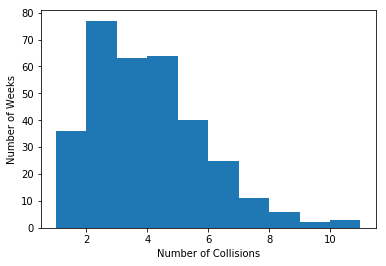

In [30]:
i = np.random.randint(numc)
print(i)
print(scorrect[clust == i])
plt.hist(cols_wk[cols_wk.Cluster == i].Collisions)
plt.xlabel('Number of Collisions')
plt.ylabel('Number of Weeks')

Finally, join station collision counts with farecard usage to compare the two.

In [31]:
rem2clus = scorrect.Cluster.reset_index()

In [32]:
rem2clus.head()

,Remote,Cluster
0,R001,200
1,R002,201
2,R003,91
3,R004,91
4,R005,92


In [33]:
farecard = pd.read_csv('MTA_FareCardUsage.csv', thousands=',')
farecard.head()

,From_Date,To_Date,Remote_Station_ID,Station,Full_Fare,Senior_Citizen___Disabled,Seven_Day_ADA_Farecard_Access_System_Unlimited,Thirty_Day_ADA_Farecard_Access_System_Unlimited,Joint_Rail_Road_Ticket,Seven_Day_Unlimited,...,LIB_Special_Senior,Rail_Road_Unlimited_No_Trade,Transit_Check_Metrocard_Annual_Metrocard,Mail_and_Ride_EZPass_Express,Mail_and_Ride_Unlimited,Path_2_Trip,Airtran_Full_Fare,Airtran_Thirty_Day,Airtran_One0_Trip,Airtran_Monthly
0,1/19/19,1/25/19,R001,WHITEHALL STREET,51485,2392,347,1003,219,21801,...,528,328,5448,2012,735,0,1111,0,0,0
1,1/19/19,1/25/19,R003,CYPRESS HILLS,2657,143,12,34,0,2134,...,79,5,94,26,27,0,21,0,0,0
2,1/19/19,1/25/19,R004,75TH STREET & ELDERTS LANE,6390,354,57,138,2,4604,...,203,0,283,39,60,0,55,0,0,0
3,1/19/19,1/25/19,R005,85TH STREET & FOREST PKWAY,7066,497,71,178,1,4424,...,195,5,246,57,61,0,55,0,0,0
4,1/19/19,1/25/19,R006,WOODHAVEN BOULEVARD,7117,450,56,167,0,6444,...,233,11,338,70,65,0,61,0,0,0


In [34]:
fc = farecard.merge(rem2clus, how='left', left_on='Remote_Station_ID', right_on='Remote').dropna()

In [35]:
colms = ['Full_Fare',
       'Senior_Citizen___Disabled',
       'Seven_Day_ADA_Farecard_Access_System_Unlimited',
       'Thirty_Day_ADA_Farecard_Access_System_Unlimited',
       'Joint_Rail_Road_Ticket', 'Seven_Day_Unlimited', 'Thirty_Day_Unlimited']

In [36]:
fc_wk = fc.groupby(['From_Date', 'Cluster'])[colms].sum()
fc_wk = fc_wk.reset_index()
fc_wk.Cluster = fc_wk.Cluster.astype(int)
fc_wk = fc_wk.rename(columns={"From_Date": "week"})

In [37]:
fc_wk.head()

,week,Cluster,Full_Fare,Senior_Citizen___Disabled,Seven_Day_ADA_Farecard_Access_System_Unlimited,Thirty_Day_ADA_Farecard_Access_System_Unlimited,Joint_Rail_Road_Ticket,Seven_Day_Unlimited,Thirty_Day_Unlimited
0,1/1/11,1,1535,76,3,16,0,385,593
1,1/1/11,2,2675,129,32,43,0,705,814
2,1/1/11,3,2052,161,37,38,0,429,625
3,1/1/11,4,11094,361,40,105,2,3873,3146
4,1/1/11,5,14852,579,72,182,3,4296,3867


In [38]:
fc_col = fc_wk.merge(cols_wk, how='left', on=['week', 'Cluster']).dropna()

In [2]:
fc_col = pd.read_csv('farecards_collisions.csv')

In [39]:
font = {'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

At many of the stations, including this cluster of stations at Jamaica Center, we find an interesting trend: weekly collisions has no significant correlation with full fare ridership, but it does correlate with senior and disabled ridership.

In [44]:
print(scorrect[clust == 135])

                            Station Line Name  \
Remote                                          
R025    JAMAICA CENTER-PARSONS BLVD       EJZ   
R536      AIRTRAIN JAMAICA CENTER 1         E   

                    Processed Name from Farecard Database  \
Remote                                                      
R025    JAMAICA CENTER PARSONS BLVD E_TRAIN J_TRAIN Z_...   
R536                    AIRTRAIN JAMAICA CENTER 1 E_TRAIN   

                    Processed Name from Stations Database  IsCorrect  \
Remote                                                                 
R025    Jamaica Center   Parsons Archer E_TRAIN J_TRAI...          1   
R536    Jamaica Center   Parsons Archer E_TRAIN J_TRAI...          1   

         Latitude  Longitude  Cluster  
Remote                                 
R025    40.702147 -73.801109      135  
R536    40.702147 -73.801109      135  


135


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


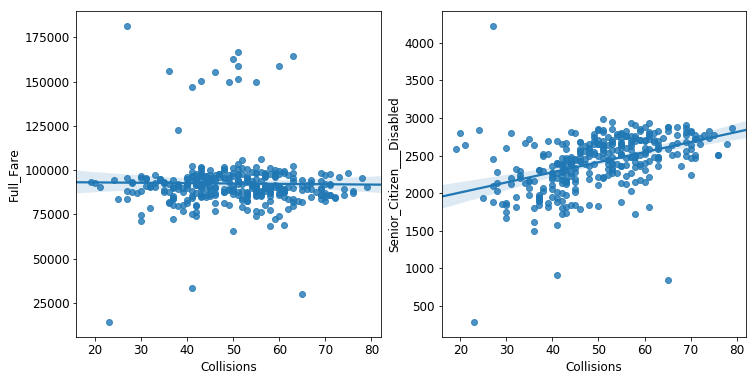

In [42]:
# Zero, positive: [135, 118, 113, 139, 37, 279, 85, 5, 267, 173, 244, 87, 95, 211]
# Negative, zero: [273, 155, 256, 147]
# Negative, positive: [162, 58, 65, 153]
i = 135 #np.random.randint(np.max(fc_col.Cluster))
print(i)

# Get trendlines

cli = fc_col[fc_col.Cluster == i]
f = plt.figure(figsize=(12,6))
f.add_subplot(121)
plt.ylabel('Full Fare Riders')
plt.xlabel('Collisions')
sns.regplot(cli['Collisions'], cli['Full_Fare'])
f.add_subplot(122)
plt.ylabel('Senior / Disabled Riders')
plt.xlabel('Collisions')
sns.regplot(cli['Collisions'], cli['Senior_Citizen___Disabled'])

f.savefig('scatterplot.png')